In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/manika/Desktop/Python : Learning/market-microstructure-analyzer/data/df_merged.csv')

In [6]:
df.drop(columns='Unnamed: 0',inplace=True)

In [13]:
df['mid_price'] = ((df['bid_price1']+df['ask_price1'])/2)/10000

Feature 1: Mid-Price Change Rate
Why: Sudden price changes may follow spoofing patterns.

In [15]:
df['mid_price_diff'] = df['mid_price'].diff().fillna(0)

Feature 2: Bid-Ask Spread
This measures market tightness (manipulators often distort this).

Best Ask (ask_price_1): Lowest price someone is willing to sell.
Best Bid (bid_price_1): Highest price someone is willing to buy.

large spreads → low liquidity or manipulation moments.

In [17]:
df['spread'] = (df['ask_price1'] - df['bid_price1'])/10000

Feature 3: Rolling Cancel-to-New Ratio
We'll create a column that identifies cancel events and new orders, then compute the ratio over a window of 50 rows

Why: Quote stuffers often place and cancel lots of fake orders.

If many cancel orders happen but few new ones → the ratio will spike upward.
High cancel_new_50 values are potential red flags for:
- Quote stuffing
- Spoofing

In [19]:
df['is_cancel'] = df['type']==2
df['is_new'] = df['type']==1

# Rolling sums over past 50 events
df['cancel_50'] = df['is_cancel'].rolling(window=50).sum()
df['new_50'] = df['is_new'].rolling(window=50).sum()

df['cancel_new_50'] = df['cancel_50']/(df['new_50']+1e-6)

Feature 4: Volume Skew
Check whether buy or sell side dominates:

In [22]:
df['volume_skew'] = (df['bid_volume1'] - df['ask_volume1']) / (df['bid_volume1'] + df['ask_volume1'] + 1e-6)


Checking distribution of the new features

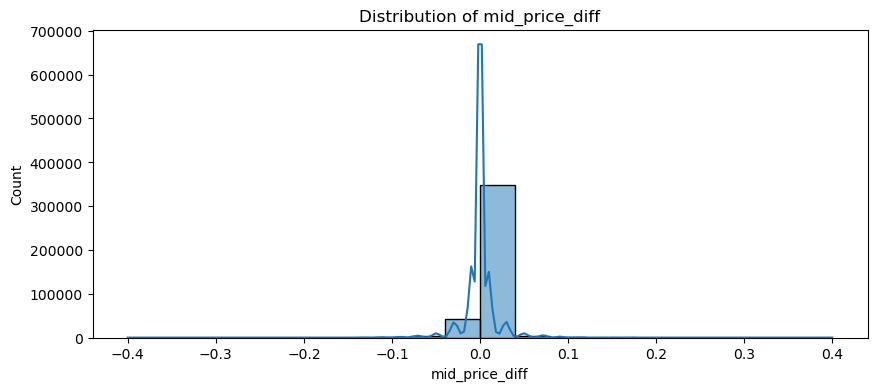

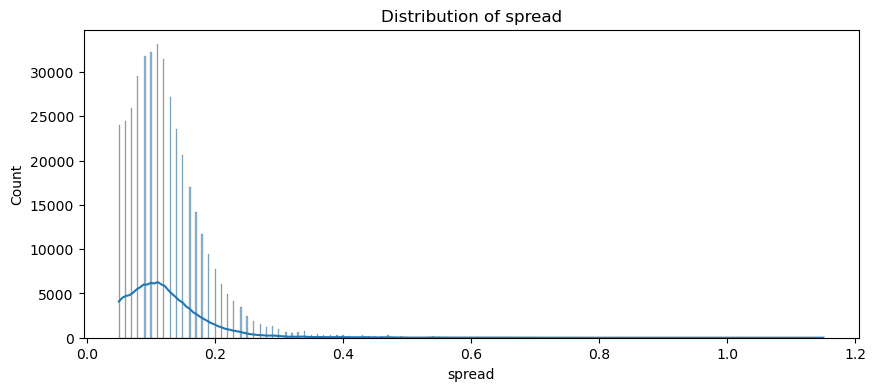

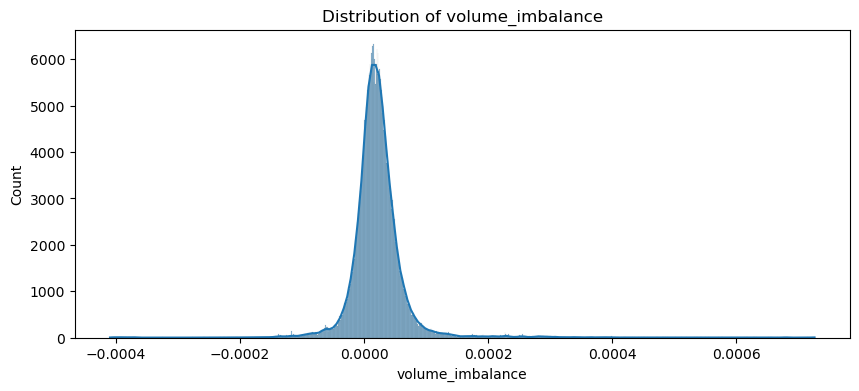

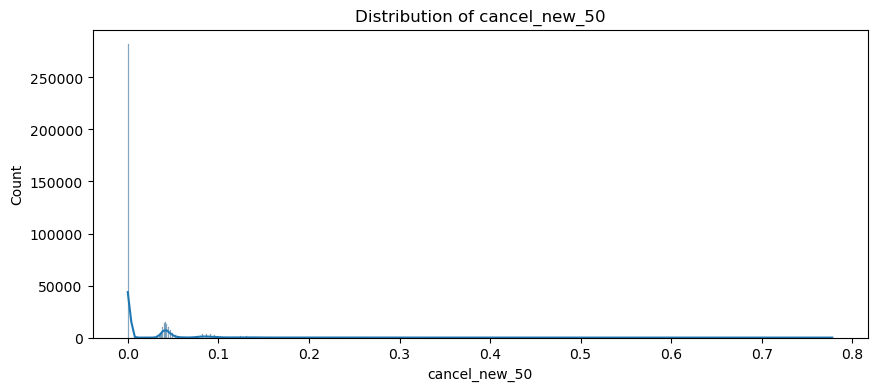

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_cols = ['mid_price_diff', 'spread', 'volume_imbalance', 'cancel_new_50']

for col in feature_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


In [25]:
# checking for correlation
df[feature_cols].corr()


,mid_price_diff,spread,volume_imbalance,cancel_new_50
mid_price_diff,1.000000,0.040938,-0.004715,0.005409
spread,0.040938,1.000000,0.030364,-0.002633
volume_imbalance,-0.004715,0.030364,1.000000,-0.005762
cancel_new_50,0.005409,-0.002633,-0.005762,1.000000


All your features are independent.
Each feature gives unique information about the market.

In [27]:
df[feature_cols].isna().sum()

mid_price_diff       0
spread               0
volume_imbalance     0
cancel_new_50       49
dtype: int64

In [29]:
# for later anomaly detection, this helps eliminate the rows having NaN
df.dropna(subset=feature_cols, inplace=True)

In [30]:
# flagging rows where features are extreme compared to the norm

from scipy.stats import zscore

df['cancel_new_z'] = zscore(df['cancel_new_50'].fillna(0))
df[df['cancel_new_z'] > 3].head()


,time,type,order_id,size,price,direction,datetime,bid_price1,bid_price2,bid_price3,...,mid_price,mid_price_diff,spread,is_cancel,is_new,cancel_50,new_50,cancel_new_50,volume_skew,cancel_new_z
7202,34457.090143,3,22606490,100,5872200,1,2024-01-01 09:34:17.090143,5875000,185,5872900,...,587.625,0.0,0.25,False,False,2.0,16.0,0.125,0.000375,3.026596
7998,34499.901415,2,23208275,100,5870000,1,2024-01-01 09:34:59.901415,5874500,100,5871500,...,587.540,0.0,0.18,True,False,3.0,24.0,0.125,0.000332,3.026596
7999,34500.116427,5,0,1,5871600,1,2024-01-01 09:35:00.116427,5874500,100,5871500,...,587.540,0.0,0.18,False,False,3.0,24.0,0.125,0.000332,3.026596
8002,34501.145588,5,0,115,5872000,1,2024-01-01 09:35:01.145588,5874000,100,5871500,...,587.485,0.0,0.17,False,False,3.0,24.0,0.125,0.000332,3.026596
8003,34501.145588,5,0,185,5871700,1,2024-01-01 09:35:01.145588,5874000,100,5871500,...,587.485,0.0,0.17,False,False,3.0,24.0,0.125,0.000332,3.026596
